## Object Detection with Tensorflow Object Detection API and OpenCV using FasterRCNN,SSD

Problem Statement: To count the number of objects in a Image

#### Import the required libraries

In [1]:
pip install tensorflow-object-detection-api

In [2]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

import cv2
import pathlib

from PIL import Image
from IPython.display import display

#from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import matplotlib.pyplot as plt

%matplotlib inline

### [COCO](http://cocodataset.org/#home) dataset

COCO (Common Objects in Context) is a large-scale object detection, segmentation, and captioning dataset. It has 80 object categories and around 1.5 million object instances

!["COCO"](img/coco.jpg)

#### Read the COCO dataset Label Names and ID

    Coco defines 91 classes but the data only uses 80 classes
    
Ref: https://www.tensorflow.org/datasets/catalog/coco


The class labels are stored in a .pbtxt file which is created by using [Google Protocol Buffers](https://developers.google.com/protocol-buffers/docs/reference/cpp/google.protobuf.text_format) which serializes the data into binary format(.pb)/ text format(.pbtxt)

In [4]:
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)
print(PATH_TO_LABELS) # File gets stored at this path : /root/.keras/datasets/mscoco_label_map.pbtxt


/root/.keras/datasets/mscoco_label_map.pbtxt


In [5]:
from object_detection.utils import label_map_util
label_map_util.tf = tf.compat.v1
tf.gfile = tf.io.gfile

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)


In [6]:
len(category_index)

80

In [7]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

### Load the model

#### Function to download, save and load the pretrained model 

In [8]:
'''
This function will download the pretrained model from 
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
and will save the loaded model in 
/Users/username/.keras/datasets/ssd_mobilenet_v1_coco_2017_11_17/saved_model
Input: Model name 
Output: Saved model
'''

def load_model(model_name):
    
    # url to download the predtrained model
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    
    # Downloads the pretrained model from the url 
    model_dir = tf.keras.utils.get_file(fname = model_name, 
                                        origin = base_url + model_file,
                                        untar = True)
    
    print(model_dir)
    # Loads the downloaded model
    model_dir = pathlib.Path(model_dir)/"saved_model"
    model = tf.saved_model.load(str(model_dir))
    
    return model

#### Load the faster rcnn model 
Get the versions of models from [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)

In [9]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
detection_model = load_model(model_name)

/root/.keras/datasets/faster_rcnn_inception_v2_coco_2018_01_28
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#### Display the layers of the model

In [10]:
for op in detection_model.graph.get_operations():
    print(op.name)

Streaming output truncated to the last 5000 lines.
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ChangeCoordinateFrame_43/Scale/concat
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/Shape_45
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/strided_slice_45/stack
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/strided_slice_45/stack_1
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/strided_slice_45/stack_2
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/strided_slice_45
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/Minimum_43/x
SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/Minimum_43
SecondStagePostproce

#### Get the model input and output tensor shapes using model signature

    Signature defines the inputs, outputs for a function

In [11]:
detection_model = detection_model.signatures['serving_default']

#### Model inputs

In [12]:
detection_model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

#### Model Outputs:

num_detections: 

    The number of detected bounding boxes.

detection_boxes: 

    A list of relative (value in [0,1]) coordinates ([ymin, xmin, ymax, xmax]) of the detection bounding boxes.

detection_classes: 

    A list of predicted class (integer) labels for each detection box in detection_boxes.

detection_scores: 

    A list of scores for each detection box in detection_boxes.

In [13]:
detection_model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

Model output datatype

In [14]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

#### Function to load the image

In [15]:
def load_image(image_path):
    
    # Opens and identifies the given image file.
    image = Image.open(image_path)
    
    # Convert to RGB (3x8-bit pixels, true color) mode.  
    # Get the mode of an image through the mode attribute.
    # image.mode
    image = image.convert('RGB')
        
    # Convert to numpy array
    image = np.array(image)
        
    return image    

#### Function to detect the bounding boxes, class labels and class scores

In [20]:
'''
This function is used to detect the bounding boxes, class labels and class scores
Input: Model , Image 
Output: bounding boxes ,class labels and class scores
'''
def detect_objects(model, image_numpy, cut_off = 0.5):
   
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    image_tensor = tf.convert_to_tensor(image_numpy)
    
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    image_tensor = image_tensor[tf.newaxis,...]
    
    # Run inference
    output_dict = model(image_tensor)
    
    # Get the number of detections
    # print(output_dict['detection_scores'])
    output_dict.pop('num_detections')
    
    # Get the top n detection boxes, labels and scores with detection score > cut_off
    num_detections = sum(output_dict['detection_scores'].numpy()[0] > cut_off)
    
    # Get the top n detection boxes, labels and scores (will only select the boxes having > 0.5 detection score)
    output_dict = {key:value[0, :num_detections].numpy() for key, value in output_dict.items()}
    
    output_dict['num_detections'] = num_detections
    
    # Detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    class_labels = [category_index[i]['name'] for i in output_dict['detection_classes']][0:num_detections]
    
    print(" There are {} objects in this image of class {}".format(num_detections, class_labels))
   
    return output_dict

#### Get the Images directory path

In [21]:
#pathlib.Path('images')
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/sample_data/')

In [33]:
#PATH_TO_TEST_IMAGES_DIR = pathlib.Path('images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/content/sample_data/table1.jpg')]

#### For understand
    Test load_image function.
    Test detect_objects function. 

In [34]:
image_numpy = load_image(TEST_IMAGE_PATHS[0])

print(image_numpy.shape)

output_dict = detect_objects(detection_model, image_numpy)

(336, 405, 3)
 There are 2 objects in this image of class ['cup', 'vase']


#### Function to display the image with the detected boxes

In [35]:
'''
This function is used to display the images with the detected boxes, class label and class score
Input: output dictionary of detect_objects function  
Output: box_coordinates
'''
def show_objects(image, output_dict):
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(image,
                                                       output_dict['detection_boxes'],
                                                       output_dict['detection_classes'],
                                                       output_dict['detection_scores'],
                                                       category_index,
                                                       use_normalized_coordinates=True,
                                                       line_thickness=8)
    display(Image.fromarray(image))

### Detect the object for each Image in the Image Path directory

 There are 2 objects in this image of class ['cup', 'vase']


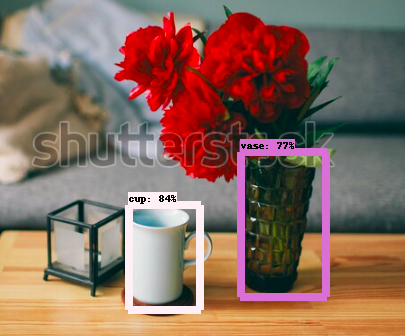

In [36]:
#bounding_box_fasterrcnn = pd.DataFrame(columns=['filename', 'class', 'confidence',
#                                                'xmin', 'ymin', 'xmax', 'ymax'])

for image_path in TEST_IMAGE_PATHS:
    
    image_numpy = load_image(image_path)
    
    output_dict = detect_objects(detection_model,image_numpy)
    
    show_objects(image_numpy, output_dict)

### Build Single shot detection model

In [37]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

/root/.keras/datasets/ssd_mobilenet_v1_coco_2017_11_17
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [38]:
for op in detection_model.graph.get_operations():
    print(op.name)

Streaming output truncated to the last 5000 lines.
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Area/Squeeze
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Greater/y
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Greater
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Where
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Reshape/shape
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Reshape
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Cast
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ClipToWindow_3/Gather/Gather
Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonM

### Get the model signature to know its inputs and outputs

In [39]:
 detection_model = detection_model.signatures['serving_default']

In [40]:
detection_model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

In [41]:
detection_model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

### Detect the object for each Image in the Image Path directory

 There are 2 objects in this image of class ['cup', 'vase']


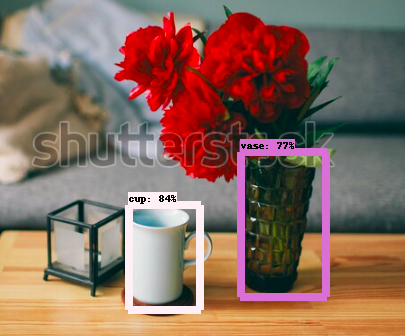

In [42]:
#pred_bounding_box_ssd = pd.DataFrame(columns=['filename', 'class', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax'])

for image_path in TEST_IMAGE_PATHS:
    
    image_numpy = load_image(image_path)
    
    output_dict = detect_objects(detection_model, image_numpy)
    
    show_objects(image_numpy, output_dict)